In [ ]:
#| default_exp modified_efficient_importance_sampling

# Modified Efficient Importance Sampling

Modified efficient importance sampling is used to improve on mode estimation. The goal is to minimize the variance of log-weights in importance sampling [@Zhang2007Efficient,@Koopman2019Modified]. If the importance sampling model is a gaussian one where observations are conditionally independent across time and space, its iterations reduce to a least squares problem which can be solved efficiently.

$$
\int \left(\log p (y | x) - \log g(y|x) - \lambda \right)^2 \log p(x|y) \mathrm d x
$$
where $\lambda = \mathbf E \left(\log p(y|x) - \log g(z|x)| Y = y\right)$. This is approximated by an importance sampling version 

$$
\sum_{i = 1}^N \left(\log p(y|X^i) - \log g(z|X^i) - \lambda\right) w(X^i).
$$

Using gaussian proposals $g$ we have for signals $S_t = B_t X_t$

$$
\begin{align*}
\log g(z_{t}|s_{t}) &= -\frac{1}{2} (z_{t} - s_{t})^T\Omega^{-1}_{t}(z_{t} - s_{t}) - \frac{p}{2} \log (2\pi) - \frac{1}{2} \log \det \Omega_{t}.
\end{align*}
$$
where $\Omega_t = \operatorname{diag} \left( \omega_{t,1}, \dots, \omega_{t,p}\right)$.



Due to the large dimension of the problem we solve it for each $t$ separately

$$
\begin{align*}
\sum_{i = 1}^N(\log p(y_t|s_t^{i}) - \log g(z_{t}| s_t^{i}) - \lambda_{t})^2 w(s_t^i) &= \sum_{i = 1}^N\left(\log p(y_t|s_t^{i}) +\frac{1}{2} (z_{t} - s_{t}^{i})^T\Omega^{-1}_{t}(z_{t} - s_{t}^{i}) + \frac{p}{2} \log (2\pi) + \frac{1}{2} \log \det \Omega_{t} - \lambda_{t}\right)^2 w(s_t^i) 
%&=  \sum_{i = 1}^{N}(\log p(y_t|s_t^{i}) - (- 2 \Omega_t ^{-1}z_t)^{T} s^{i}_t -  (s^{i}_t)^T\Omega_t^{-1}s^{i}_t - \lambda_t - C_t)^2w(s_t^i) \\
%&= \sum_{i = 1}^N \left(\log p(y_t|s_t^{i}) - (s^{i}_t)^{T}(- 2 \Omega_t ^{-1}z_t) + \frac{1}{2} \sum_{j = 1}^{p} (s^{i}_{t,j})^{2} \frac{1}{\omega_{t,j}} - \lambda_t - C_t \right)
\end{align*}
$$

and minimized over the unknown parameters $\left(z_t, \Omega_t, \lambda_t - C_t\right)$, which is a weighted least squares setting with "observations" $\log p(y_t|s_t)$.



At time $t$ the problem can be formulated as the following constrained linear least squares problem:

$$
\begin{align*}
    \min_{x} (y - Ax)^{T} W (y - Ax) &= x^{T}A^{T}W Ax - 2 y^{T} W Ax + y^{T}Wy= \frac{1}{2} x^{T}Qx + c^Tx + y^{T}Wy \\
    \text{subject to ~ ~ ~ ~ ~} & l \leq x \leq u
\end{align*}
$$
where
$$
\begin{align*}
    y &=  \left(\log p(y_{t}| s_{y}^{1}), \dots, \log p(y_{t}|s_{t}^N)\right)^{T} &\in \mathbf{R}^{N}\\
    A &= \left( \mathbf 1_{(N, 1)}, S, -\frac{1}{2} S^{2}  \right) &\in \mathbf{R}^{N \times (2p + 1)}\\
    S = (S_{i,j}) &= s_{t,j}^i &\in \mathbf{R}^{N \times p}\\
    x &= \left(C_{t}, \frac{z_{t}^{1}}{\omega_{t}^1}, \dots, \frac{z_{t}^p}{\omega_{t}^p}, \frac{1}{\omega_{t}^1}, \dots, \frac{1}{\omega_{t}^p}\right) &\in \mathbf{R}^{2p + 1}\\
    C_{t} &= \lambda_{t} - \frac{1}{2}\log\det \Omega_{t} - \frac{p}{2}\log(2\pi) - \frac{1}{2} z_{t}^T\Omega_{t}^{-1}z_{t} &\in \mathbf{R}\\
    W &= \operatorname{diag} \left( w(s_{t}^1), \dots, w(s_{t}^N)\right) &\in \mathbf{R}^{N\times N}\\
    Q &= 2 A^{T}W A  &\in \mathbf{R}^{(2p + 1) \times (2p + 1)}\\
    c &= - 2 A^{T}Wy &\in \mathbf{R}^{2p+1}
\end{align*}
$$


In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from isssm.glssm import FFBS
from isssm.importance_sampling import log_weights_t, normalize_weights
from functools import partial
from jax.lax import scan
from jaxopt import BoxCDQP


def modified_efficient_importance_sampling(
    y, x0, A, Sigma, B, xi, dist, z_init, Omega_init, n_iter, N, key
):
    np1, p = y.shape
    n = np1 - 1

    lw_t = vmap(
        lambda s, z, Omega: log_weights_t(s,y,xi,dist,z,Omega),
        (0,0,0)
    )

    vB = vmap(partial(vmap(jnp.matmul), B))
    v_norm_w = vmap(normalize_weights)

    key, subkey = jrn.split(key)

    def iteration(carry, inputs):
        a, z, Omega = carry
        samples = FFBS(z, x0, Sigma, Omega, A, B, N, subkey)

        signals = vB(samples)

        # (N, n+1) -> (n+1, N)
        log_p = dist(signals, xi).log_prob(y).T.sum(axis=0)

        # (N, n+1) -> (n+1, N)
        w_s_t = vmap(lambda s: lw_t(s, z, Omega), 0)(signals).T
        w_s_t_norm = v_norm_w(w_s_t)

        # (N, n+1, p) -> (n+1, N, p)
        design_lsq = jnp.dstack((jnp.ones((N, n+1, 1)), signals, -0.5 * signals**2)).transpose(
            (1, 0, 2)
        )

        ## initial guess by solving unconstrained least squares problem
        ## this turned out to be inferior to using the previous estimate
        #opt_lambda = lambda A, x: jnp.linalg.lstsq(A,x)
        #x0s, *_ = vmap(opt_lambda)(jnp.sqrt(w_s_t_norm)[:, :, None] * design_lsq, (jnp.sqrt(w_s_t_norm) * log_p))

        ## flip signs if necessary for feasible point
        #signs = jnp.sign(x0s[:, p+1:])
        #x0s = jnp.hstack((
        #    x0s[:, 0:1],
        #    x0s[:, 1 : (p + 1)] * signs,
        #    jnp.abs(x0s[:, (p + 1):])
        #))

        x0s = jnp.hstack((
            a[:, None],
            z / vmap(jnp.diag)(Omega),
            1/vmap(jnp.diag)(Omega),
        ))    
        
        def optimize(A, y, w, x0):
            solver = BoxCDQP()

            # diag(w) @ A inefficient, directly multiply rows of A by w
            Q = 2 * A.T @ (w[:,None] * A)
            c = -2 * A.T @ (w*y)

            l = jnp.concatenate((jnp.full(p+1, -jnp.inf), jnp.full(p, 1e-10)))
            u = jnp.full(2*p+1, jnp.inf)
            
            result = solver.run(
                x0,
                params_obj=(Q, c),
                params_ineq=(l, u),
            ).params
            return result

        wls_estimate = vmap(optimize)(
            design_lsq,
            log_p,
            w_s_t_norm,
            x0s,
        )


        a = wls_estimate[:, 0]
        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]

        # sometimes optimal variances are negative, in this case 
        # solve constrained least squares problem to ensure valid
        # solution

        z_new = b / c
        Omega_new = vmap(jnp.diag)(1 / c)

        return (a, z_new, Omega_new), None
        
    (_, z, Omega), _ = scan(iteration, (jnp.zeros(np1), z_init, Omega_init), (jnp.arange(n_iter),))
    
    return z, Omega

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:127: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  samps = jaxrand.gamma(


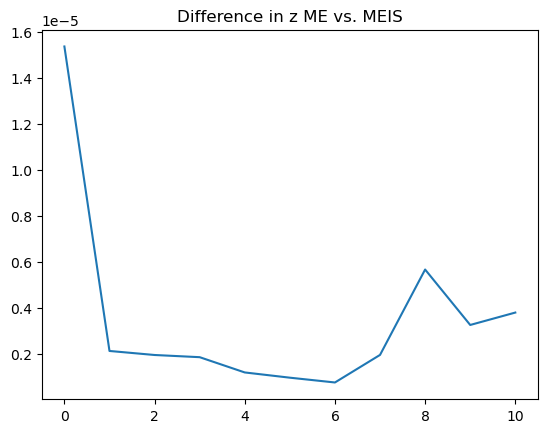

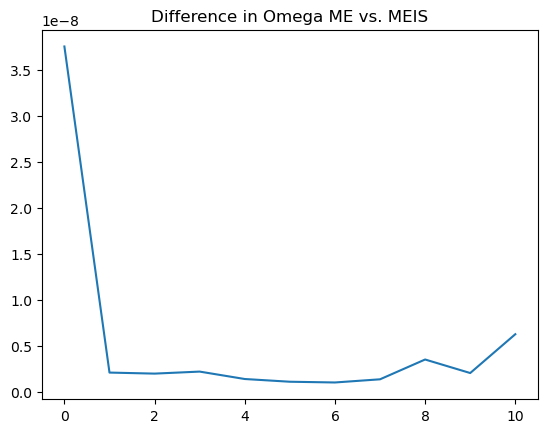

In [ ]:
from isssm.importance_sampling import log_weights
from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.glssm import FFBS
from isssm.kalman import kalman
import jax.random as jrn
from isssm.mode_estimation import mode_estimation
import jax.numpy as jnp
from jax import vmap
from functools import partial
import matplotlib.pyplot as plt

m, p, n = 3, 2, 10
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
x0 = jnp.ones(m)

key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
*_, dist, xi = nb_lcssm(x0, A, Sigma, B, 20.)
N = 1
(x, ), (y,) = simulate_lcssm(x0, A, Sigma, B, dist, xi, N, subkey)
s_init = jnp.log(y + 1.)
x_smooth, z, Omega = mode_estimation(y, x0, A, Sigma, B, dist, xi, s_init, 100)

key, subkey = jrn.split(key)
z_meis, Omega_meis = modified_efficient_importance_sampling(
    y, x0, A, Sigma, B, xi, dist, z, Omega, 10, 1000, subkey
)
z_diff = ((z_meis - z)**2).mean(axis=1)
plt.title("Difference in z ME vs. MEIS")
plt.plot(z_diff)
plt.show()

Omega_diff = ((Omega_meis - Omega)**2).mean(axis=(1,2))
plt.title("Difference in Omega ME vs. MEIS")
plt.plot(Omega_diff)
plt.show()

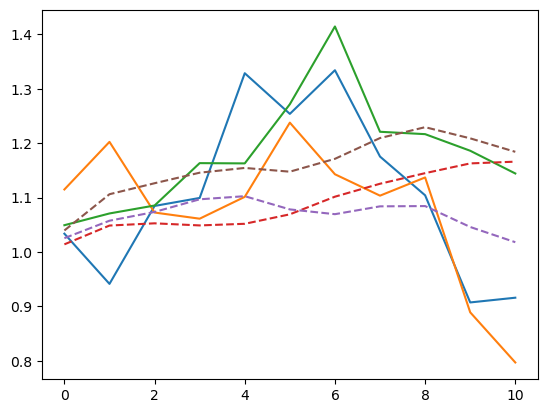

In [ ]:
from isssm.kalman import kalman, smoother
x_filt, Xi_filt, x_pred, Xi_pred = kalman(z_meis, x0, Sigma, Omega_meis, A, B)
x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)


plt.plot(x)
plt.plot(x_smooth, linestyle="--")
plt.show()

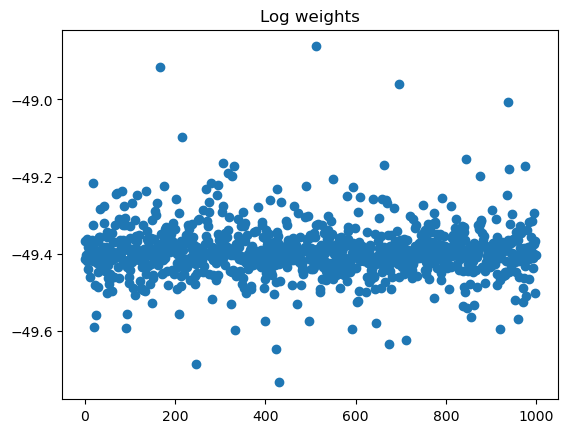

In [ ]:
N = 1000
samples = FFBS(z_meis, x0, Sigma, Omega_meis, A, B, 1000, jrn.PRNGKey(423423))

vB = partial(vmap(jnp.matmul), B)

s = vmap(vB)(samples)

vlw = vmap(log_weights, (0, None, None, None, None, None))
lw = vlw(s, y, dist, xi, z, Omega)
plt.title("Log weights")
plt.scatter(jnp.arange(N), lw)
plt.show()

In [ ]:
from isssm.importance_sampling import ess_lw

ess_lw(lw) / lw.shape[0] * 100

Array(99.4607, dtype=float32)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()